# Health Monitoring - Item Sales (Target)

This notebook provides a comprehensive analysis of the target variable's health for demand forecasting. It covers data quality, statistical tests, visualizations, and model evaluation to ensure robust forecasting.


## Executive Summary

- **Goal:** Assess the reliability and stability of the target variable for forecasting.
- **Approach:** Stationarity analysis, change point detection, drift monitoring, and time series modeling.
- **Key Findings:** 
    - Clear Seasonal Pattern
    - Trend is present in total sales
    - Target requires Log-Normal Transformation
    - Filter out 95th percentile of target values
    - There is data drift present in the last 12 months (2016).

## 1. Setup & Configuration

Import required libraries and set up parameters.

In [14]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import ks_2samp
import ruptures as rpt
import sys
import os

# --- Imports from project root ---
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(project_root)
from src.core.clients.bigquery import BigQueryClient

# --- Plotting style ---
sns.set(style='whitegrid', context='notebook')

In [15]:
# --- Load Data From BigQuery ---
from src.core.clients.bigquery import BigQueryClient

bq_client = BigQueryClient()

sales_query = """
    SELECT 
        tgt.ctx_date_month,
        tgt.ctx_cat_id, 
        tgt.ctx_dept_id, 
        tgt.ctx_item_id,
        tgt.tgt_monthly_sales,
        tgt.tgt_monthly_sales_sum_3_next_months
    FROM `porygon-pipelines.walmart_targets_and_filters.target_store_item_monthly` tgt
    LEFT JOIN `porygon-pipelines.walmart_targets_and_filters.stockout_filter` stckt
        ON tgt.ctx_item_id = stckt.ctx_item_id
        AND tgt.ctx_store_id = stckt.ctx_store_id
        AND tgt.ctx_date_month = stckt.ctx_date_month
    LEFT JOIN `porygon-pipelines.walmart_featurestore.item_longevity_features` long
        ON tgt.ctx_item_id = long.ctx_item_id
        AND tgt.ctx_date_month = long.ctx_date_month
    WHERE 
        tgt.ctx_store_id = 'CA_1'
        AND stckt.is_stockout_tgt = 0
        AND long.fea_item_longevity_months >=0
"""


# Extract data
df = bq_client.load_from_query(sales_query)

# Define target name to analyze:
target_name = "tgt_monthly_sales_sum_3_next_months"

INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:src.core.clients.bigquery:Loaded 110992 rows from custom query.


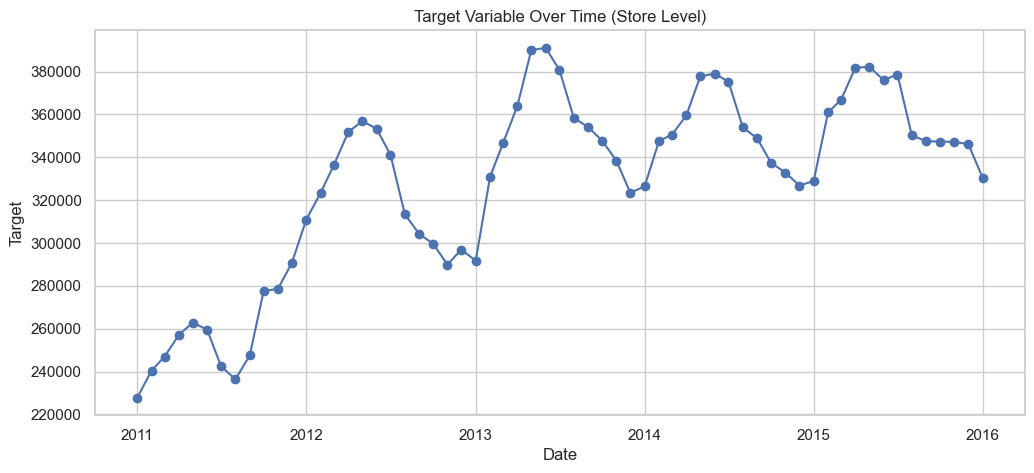

In [16]:
# Aggregate at store level (or by department/item as needed)
df_store = df.groupby('ctx_date_month')[target_name].sum().sort_index()

# Plot target variable over time
plt.figure(figsize=(12, 5))
plt.plot(df_store.index, df_store.values, marker='o')
plt.title('Target Variable Over Time (Store Level)')
plt.xlabel('Date')
plt.ylabel('Target')
plt.show()

## 2. Stationarity Analysis

Apply Augmented Dickey-Fuller (ADF) and KPSS tests to assess stationarity.

In [17]:
def run_stationarity_tests(series):
    """Run ADF and KPSS tests and print results."""
    adf_result = adfuller(series)
    print(f'ADF Statistic: {adf_result[0]:.3f}, p-value: {adf_result[1]:.3f}')
    kpss_result = kpss(series, regression='ct', nlags='auto')
    print(f'KPSS Statistic: {kpss_result[0]:.3f}, p-value: {kpss_result[1]:.3f}')

run_stationarity_tests(df_store)

ADF Statistic: -4.098, p-value: 0.001
KPSS Statistic: 0.181, p-value: 0.023


**Conclussions**
- According to ADF the time series is stationary and according to KPSS the time series is non-stationary. 
- ADF is sensitive to unit root and KPSS is sensitive to trend (or level) instability 
- This probabily means the time series does not have a unit root, but does have a trend. 

## 3. Change Point Detection

2011-10-01
2016-01-01


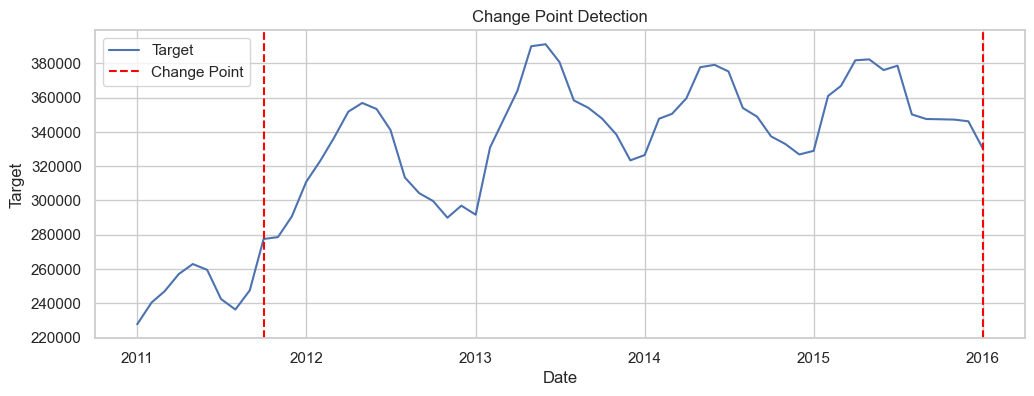

In [18]:
# Detect change points in the target variable
ts = df_store.values
algo = rpt.Pelt(model='rbf').fit(ts)
result = algo.predict(pen=10)

plt.figure(figsize=(12, 4))
plt.plot(df_store.index, ts, label='Target')
for i, cp in enumerate(result):
    plt.axvline(df_store.index[cp-1], color='red', linestyle='--', label='Change Point' if i == 0 else None)
    print(df_store.index[cp-1])
plt.title('Change Point Detection')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()

plt.show()

**Conclussions**
- There are two dates where the statistical properties of the data changed (mean, variance or both).

## 4. Autocorrelation Analysis

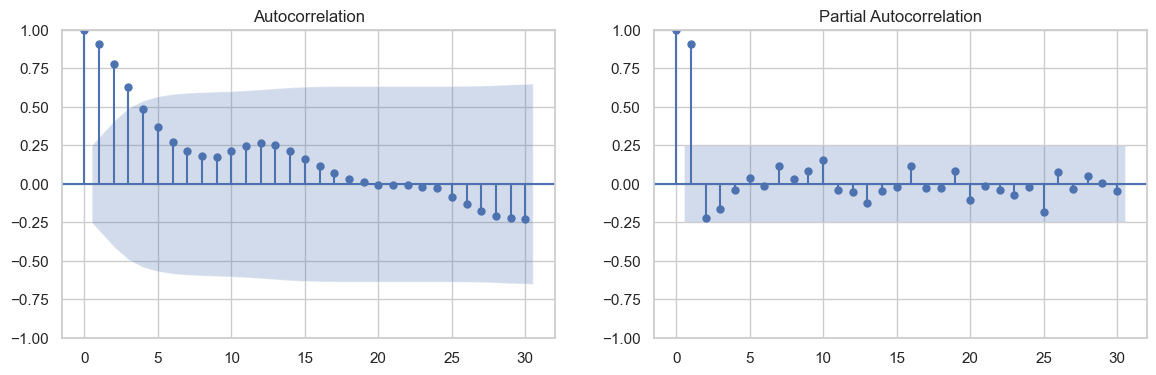

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(df_store, ax=axes[0], lags=30)
axes[0].set_title('Autocorrelation')
plot_pacf(df_store, ax=axes[1], lags=30)
axes[1].set_title('Partial Autocorrelation')
plt.show()

**Conclussions**
- The partial autocorrelation plot shows that the last three lags have partial autocorrelation.

**Conclussion**
- Significant data drift from 2011 to 2016. 
- This may be tied to the identified trend. 

## 5. ARIMA and SARIMA Modeling

Fit ARIMA and SARIMA models to the aggregated target time series (`df_store`).

                                        SARIMAX Results                                        
Dep. Variable:     tgt_monthly_sales_sum_3_next_months   No. Observations:                   61
Model:                                  ARIMA(1, 1, 1)   Log Likelihood                -655.025
Date:                                 Sat, 24 Jan 2026   AIC                           1316.051
Time:                                         14:22:20   BIC                           1322.334
Sample:                                     01-01-2011   HQIC                          1318.508
                                          - 01-01-2016                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4231      0.630      0.672      0.502      -0.811       1

/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


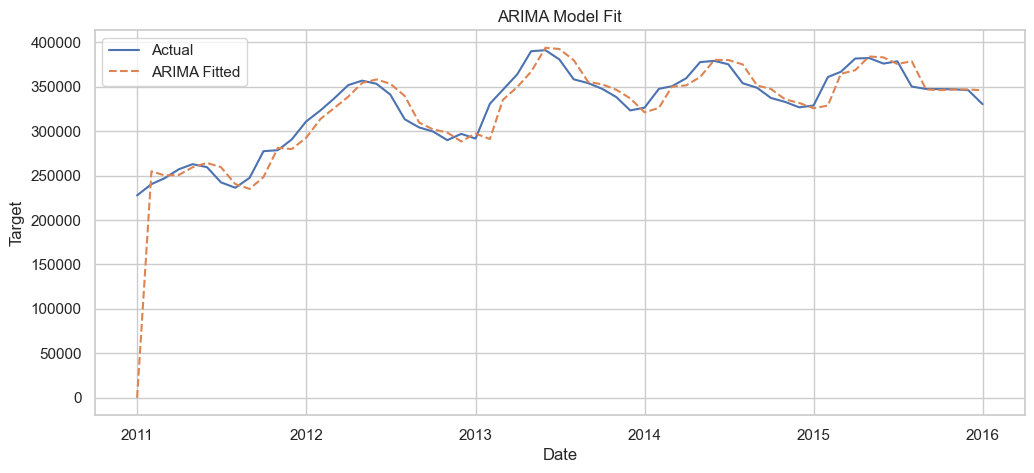

In [20]:
# Fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA (order can be tuned or selected via auto_arima)
arima_model = ARIMA(df_store, order=(1,1,1))
arima_result = arima_model.fit()
print(arima_result.summary())

# Plot ARIMA fitted values
plt.figure(figsize=(12,5))
plt.plot(df_store.index, df_store.values, label='Actual')
plt.plot(df_store.index, arima_result.fittedvalues, label='ARIMA Fitted', linestyle='--')
plt.title('ARIMA Model Fit')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.show()

                                        SARIMAX Results                                        
Dep. Variable:     tgt_monthly_sales_sum_3_next_months   No. Observations:                   61
Model:                  SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -516.647
Date:                                 Sat, 24 Jan 2026   AIC                           1043.294
Time:                                         14:22:20   BIC                           1052.650
Sample:                                     01-01-2011   HQIC                          1046.830
                                          - 01-01-2016                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8695      0.398      2.185      0.029       0.090       1

/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zer

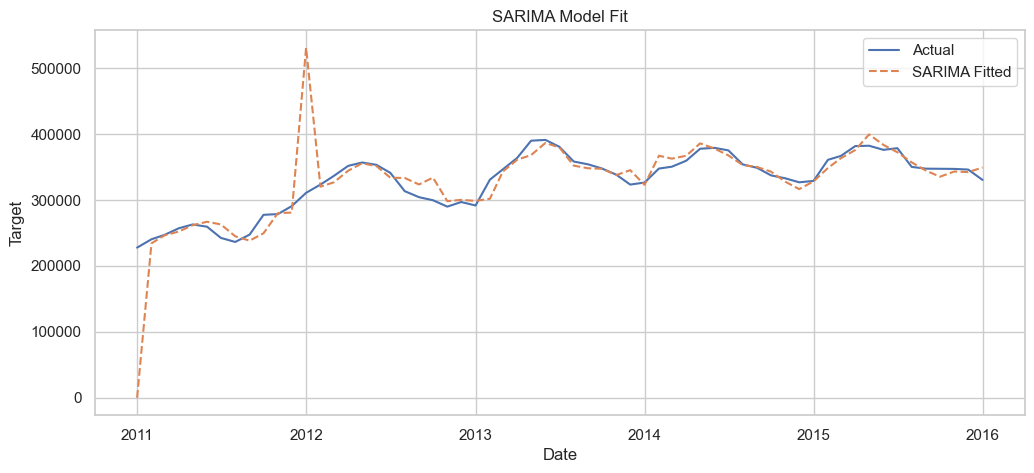

In [21]:
# Fit SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Example: SARIMA(1,1,1)x(1,1,1,12) for monthly data (adjust seasonal_order as needed)
sarima_model = SARIMAX(df_store, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_result = sarima_model.fit(disp=False)
print(sarima_result.summary())

# Plot SARIMA fitted values
plt.figure(figsize=(12,5))
plt.plot(df_store.index, df_store.values, label='Actual')
plt.plot(df_store.index, sarima_result.fittedvalues, label='SARIMA Fitted', linestyle='--')
plt.title('SARIMA Model Fit')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.show()

## 6. Model Error Metrics

Evaluate ARIMA and SARIMA model performance using common error metrics: MAE, RMSE, and MAPE.

In [22]:
# Calculate error metrics for ARIMA and SARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100

# ARIMA metrics
arima_pred = arima_result.fittedvalues
mae_arima = mean_absolute_error(df_store, arima_pred)
rmse_arima = np.sqrt(mean_squared_error(df_store, arima_pred))
mape_arima = mean_absolute_percentage_error(df_store, arima_pred)

# SARIMA metrics
sarima_pred = sarima_result.fittedvalues
mae_sarima = mean_absolute_error(df_store, sarima_pred)
rmse_sarima = np.sqrt(mean_squared_error(df_store, sarima_pred))
mape_sarima = mean_absolute_percentage_error(df_store, sarima_pred)

print('ARIMA MAE:', mae_arima)
print('ARIMA RMSE:', rmse_arima)
print('ARIMA MAPE:', mape_arima)
print('SARIMA MAE:', mae_sarima)
print('SARIMA RMSE:', rmse_sarima)
print('SARIMA MAPE:', mape_sarima)

ARIMA MAE: 13548.643704453845
ARIMA RMSE: 32015.5366962398
ARIMA MAPE: 4.66520735853163
SARIMA MAE: 15589.192177806231
SARIMA RMSE: 42110.528190847865
SARIMA MAPE: 5.383410910319885


# 7. Explore Pareto-Distribution

Item sales tend to be pareto distributed (not a normal distribution). I will apply log normal transformation to see if I can transform it to a normal distribution this way. 

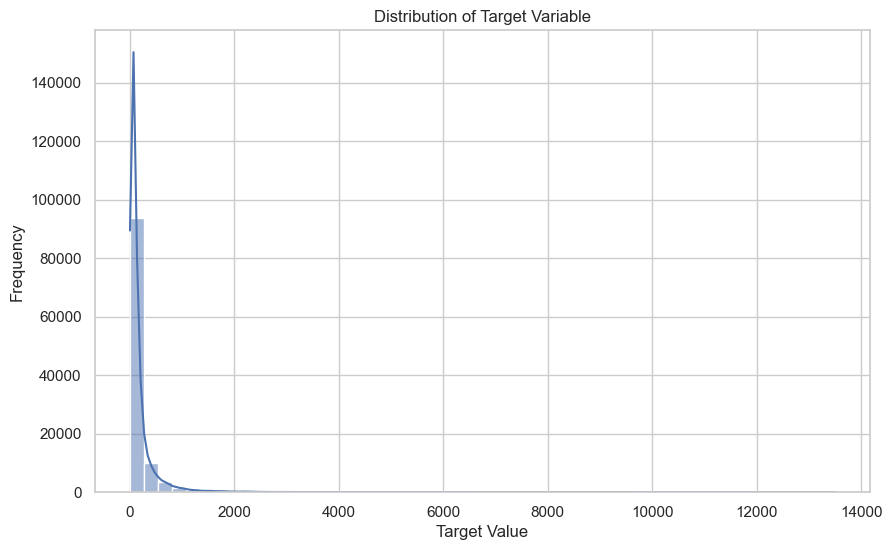

In [23]:
# Distribution of the target variable (all items, all periods)
plt.figure(figsize=(10, 6))
sns.histplot(df[target_name], bins=50, kde=True)
plt.title('Distribution of Target Variable')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

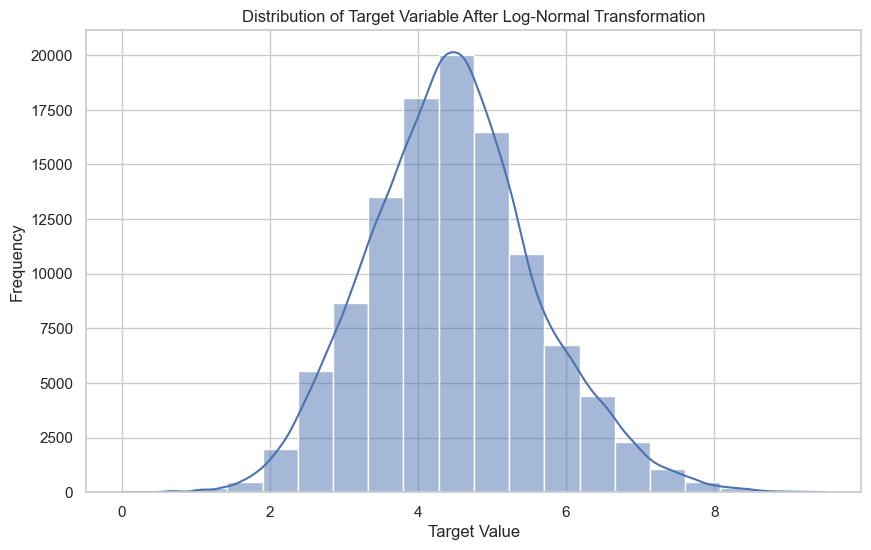

In [24]:
# Apply log normal transformation
df[f"{target_name}_transformed"] = np.log(df[target_name])
plt.figure(figsize=(10, 6))
sns.histplot(df[f"{target_name}_transformed"], bins=20, kde=True)
plt.title('Distribution of Target Variable After Log-Normal Transformation')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 8. Perform Outlier Detection

In [25]:
values = []
quants = [.80,  .90, .95, .96, .97, .98, .99]
for q in quants:
    values.append(df[target_name].quantile(q))

df_outliers = pd.DataFrame(quants, columns=["percentile"])
df_outliers["values"] = values

df_outliers["values_diff"] = df_outliers["values"].diff()
df_outliers["perc_diff"] = df_outliers["percentile"].diff()*100
df_outliers["scaled_growth"] = df_outliers["values_diff"]/df_outliers["perc_diff"]

display(df_outliers)

,percentile,values,values_diff,perc_diff,scaled_growth
0,0.80,214.00,NaN,NaN,NaN
1,0.90,394.00,180.00,10.0,18.00
2,0.95,653.00,259.00,5.0,51.80
3,0.96,743.00,90.00,1.0,90.00
4,0.97,879.00,136.00,1.0,136.00
5,0.98,1098.00,219.00,1.0,219.00
6,0.99,1610.27,512.27,1.0,512.27


**Conclussions**
- I recommend filtering after the 95th percentile.

# Data Drift Assessment

- Data seems not to have drifted considerably. 
- The data for the test set seems to be representative of the data during training. 
- Please note that this is not considering zeros as the transformation makes them into infinite values. 
- The KS Statistic suggests there is drift. Analyze this with model performance during experimentation.

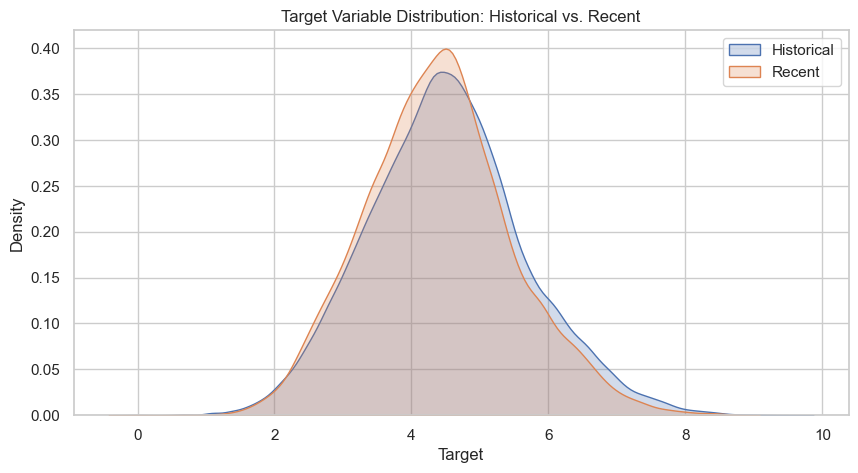

KS Statistic: 0.053, p-value: 0.000


In [26]:
# Compare recent vs. historical distributions
historical = np.log(df[df["ctx_date_month"]<=pd.to_datetime("2015-01-01")][target_name])
recent = np.log(df[df["ctx_date_month"]>pd.to_datetime("2015-01-01")][target_name])

plt.figure(figsize=(10, 5))
sns.kdeplot(historical, label='Historical', fill=True)
sns.kdeplot(recent, label='Recent', fill=True)
plt.title('Target Variable Distribution: Historical vs. Recent')
plt.xlabel('Target')
plt.legend()
plt.show()

# Kolmogorov-Smirnov test
ks_stat, ks_p = ks_2samp(historical, recent)
print(f'KS Statistic: {ks_stat:.3f}, p-value: {ks_p:.3f}')